In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import sys

In [ ]:
#middlebury
#focal length 3740 pixels
#baseline 160

Run the 2 code blocks below with img0 and img1 having chosen filenames.
The code beyond those blocks was for additional experimentation

In [1]:
def getBlock(image, row, col, blocksize, h, w):
    block = np.empty((blocksize, blocksize))
    for i in range(row-int(blocksize/2), row+1+int(blocksize/2)):
        for j in range(col-int(blocksize/2), col+1+int(blocksize/2)):
            if((i > -1 and i < h) and (j > -1 and j<w)): 
                block[i-row-int(blocksize/2),j-col-int(blocksize/2)] = image[i,j]
            else:
                block[i-row-int(blocksize/2),j-col-int(blocksize/2)] = 0 #is this the right method for padding for boundary issues?
    return block


In [4]:
maxOffset = 64 # scalefactor = int(255/maxoffset)
blocksize = 5
#pad = int((blocksize-1)/2)
img0 = cv.imread("dollsleft.png", cv.IMREAD_GRAYSCALE)
img1 = cv.imread("dollsright.png", cv.IMREAD_GRAYSCALE)
h = img0.shape[0]#rows TAKEN BEFORE PADDING
w = img0.shape[1]#cols
# img0 = np.pad(img0,((pad, pad), (pad, pad)))
# img1 = np.pad(img1,((pad, pad), (pad, pad)))
#h = img0.shape[0]#rows
#w = img0.shape[1]#cols
output = np.zeros((h, w, 1), dtype = np.uint8)
#h,w not considering padded image
for row in range(h): #for each row of left image
#for row in range(pad, h - pad):#bounds with respect to padded image
    print("\rcurrent row: %d"%row, end="",flush=True)
    for col in range(w): #for each pixel in the current row
    #for col in range(pad, w-pad):
        #calculate block score of our current block here so it is only done once
        leftBlock = getBlock(img0, row, col, blocksize, h, w)
        rightpt = -1
        disparity = 0
        bestSSD = sys.maxsize#SHOULD INSTEAD SET THIS AS OCCLUSION THRESHOLD
        for r in range(col-maxOffset,col+maxOffset): #iterations not in bounds are effectively ignored?
            #if(r<pad or r>=w-pad):
                #continue
            rightBlock = getBlock(img1, row, r, blocksize, h, w)
            diff = np.sum(np.abs(leftBlock - rightBlock))
            #diff = (leftBlock - rightBlock)**2
            if(diff < bestSSD): #found new best match
                bestSSD = diff
                disparity = abs(col-r)
        #if(bestSSD not below some threshold) (what threshold?)
        #   consider this point to be an OCCLUSION?        
        output[row,col] = (disparity * (255/maxOffset)) #divide by 3 since third size?

plt.imshow(output,'gray')
plt.show()
cv.imwrite("5_block.png",output)
####
####
#slower but better output

current row: 5

KeyboardInterrupt: 

In [ ]:
#measure accuracy
exp = cv.imread("7dolls.png", cv.IMREAD_GRAYSCALE)
groundtruth = cv.imread("dollsgt.png", cv.IMREAD_GRAYSCALE)
diff = np.sum(np.abs(groundtruth - exp))/255
h = exp.shape[0]#rows
w = exp.shape[1]#cols
accuracy = ((h*w)-diff)/(h*w)
print("accuracy reported: ", accuracy)

Junk below

In [148]:
#faster numpy block version
def getBlock(image, row, col, blocksize, h, w):
    # block = np.empty((blocksize, blocksize))
    # for i in range(row-int(blocksize/2), row+1+int(blocksize/2)):
    #     for j in range(col-int(blocksize/2), col+1+int(blocksize/2)):
    #         if((i > -1 and i < h) and (j > -1 and j<w)): 
    #             block[i-row-int(blocksize/2),j-col-int(blocksize/2)] = image[i,j]
    #         else:
    #             block[i-row-int(blocksize/2),j-col-int(blocksize/2)] = 0 #is this the right method for padding for boundary issues?
    #below runs significantly faster
    pad = int((blocksize-1)/2)
    top = row - pad
    bottom = row + pad 
    left = col - pad
    right = col + pad
    block = image[top: bottom+1, left: right+1]
    return block

current row: 371

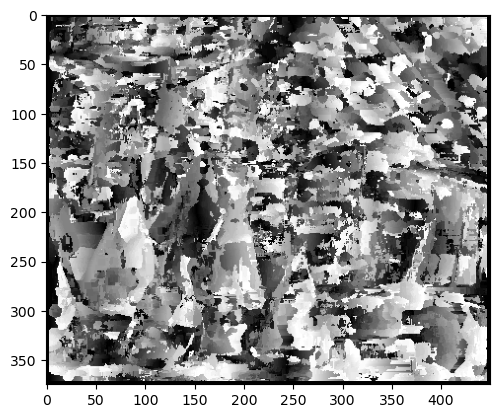

True

In [162]:
#Faster but less clean numpy implementation
maxOffset = 64
blocksize = 7
pad = int((blocksize-1)/2)
img0 = cv.imread("conesleft.png", cv.IMREAD_GRAYSCALE)
img1 = cv.imread("conesright.png", cv.IMREAD_GRAYSCALE)
h = img0.shape[0]#rows TAKEN BEFORE PADDING
w = img0.shape[1]#cols
img0 = np.pad(img0,((pad, pad), (pad, pad)))
img1 = np.pad(img1,((pad, pad), (pad, pad)))
#h = img0.shape[0]#rows
#w = img0.shape[1]#cols
output = np.zeros((h, w, 1), dtype = np.uint8)
#h,w not considering padded image
#for row in range(h): #for each row of left image
for row in range(pad, h - pad):#bounds with respect to padded image
    print("\rcurrent row: %d"%row, end="",flush=True)
    #for col in range(w): #for each pixel in the current row
    for col in range(pad, w-pad):
        #calculate block score of our current block here so it is only done once
        leftBlock = getBlock(img0, row, col, blocksize, h, w)
        rightpt = -1
        disparity = 0
        bestSSD = sys.maxsize#SHOULD INSTEAD SET THIS AS OCCLUSION THRESHOLD
        for r in range(col-maxOffset,col+maxOffset): 
            if(r<pad or r>=w-pad):
                continue
            rightBlock = getBlock(img1, row, r, blocksize, h, w)
            diff = np.sum(np.abs(leftBlock - rightBlock))
            #diff = (leftBlock - rightBlock)**2
            if(diff < bestSSD): #found new best match
                bestSSD = diff
                disparity = abs(col-r)
        #if(bestSSD not below some threshold) (what threshold?)
        #   consider this point to be an OCCLUSION?        
        output[row,col] = (disparity * (255/maxOffset)) #divide by 3 since third size?

plt.imshow(output,'gray')
plt.show()
cv.imwrite("5_block.png",output)


disparity range 0-64, set max offset as 64
*Set a threshold for ssd to deal with occlusion, set to zero if beyond threshold
*For every match match found, save ssd score. Then take average ssd score of a match as our threshold and see how that affects output

In [12]:
#measure accuracy
exp = cv.imread("7dolls.png", cv.IMREAD_GRAYSCALE)
groundtruth = cv.imread("dollsgt.png", cv.IMREAD_GRAYSCALE)
diff = np.sum(np.abs(groundtruth - exp))/255
h = exp.shape[0]#rows
w = exp.shape[1]#cols
accuracy = ((h*w)-diff)/(h*w)
print("accuracy reported: ", accuracy)



accuracy reported:  0.23155561354773646


In [85]:
#compute block score
def getBlockValue(image, row, col, blocksize, h, w): #should correctly deal with image boundaries and return the value of a
    #row and col are left
    value = 0
    for i in range(row-int(blocksize/2), row+1+int(blocksize/2)):
        for j in range(col-int(blocksize/2), col+1+int(blocksize/2)):
            if((i > -1 and i < h) and (j > -1 and j<w)): 
                value += image[i, j]
    return value

In [153]:

#######
img0 = cv.imread("im2.png", cv.IMREAD_GRAYSCALE)
img1 = cv.imread("im6.png", cv.IMREAD_GRAYSCALE)
#img0crop = img0[0:100,0:100]
#img1crop = img1[0:100,0:100]
#img0 = img0crop
#img1 = img1crop
h = img0.shape[0]#rows
w = img0.shape[1]#cols
output = np.zeros((h, w, 1), dtype = np.uint8)

maxOffset = 64
blocksize = 5
for row in range(h): #for each row of left image
#for row in range(pad, h - pad):
    print("current row: ", row)
    for col in range(w):
    #for col in range(pad, h-pad): #for each pixel in the current row
        #print("current col: ", j)
        #calculate block score of our current block here so it is only done once
        leftVal = getBlockValue(img0, row, col, blocksize, h, w)
        #differences = []#should be size w
        rightpt = -1
        disparity = 0
        bestSSD = sys.maxsize  
        for r in range(col-maxOffset,col+maxOffset): #iterations not in bounds are effectively ignored?
            rightVal = getBlockValue(img1, row, r, blocksize, h, w)
            #diff = np.sum(np.abs(leftVal - rightVal))
            diff = (leftVal - rightVal)**2
            if(diff < bestSSD): #found new best match
                bestSSD = diff
                disparity = abs(col-r)
        #if(bestSSD not below some threshold) (what threshold?)
        #   consider this point to be an OCCLUSION?        
        output[row,col] = (disparity * (255/maxOffset)) #divide by 3 since third size?

plt.imshow(output,'gray')
plt.show()
#Could finalize output by running an occlusion filling routine
###########################################################################################################

current row:  3
current row:  4
current row:  5
current row:  6
current row:  7
current row:  8
current row:  9
current row:  10
current row:  11
current row:  12
current row:  13
current row:  14
current row:  15
current row:  16
current row:  17
current row:  18
current row:  19
current row:  20
current row:  21
current row:  22
current row:  23
current row:  24
current row:  25
current row:  26
current row:  27
current row:  28
current row:  29
current row:  30
current row:  31
current row:  32
current row:  33
current row:  34
current row:  35
current row:  36
current row:  37
current row:  38
current row:  39
current row:  40
current row:  41
current row:  42
current row:  43
current row:  44
current row:  45
current row:  46
current row:  47
current row:  48
current row:  49
current row:  50
current row:  51
current row:  52
current row:  53
current row:  54
current row:  55
current row:  56
current row:  57
current row:  58
current row:  59
current row:  60
current row:  61
curr

KeyboardInterrupt: 

current row:  0


/var/folders/4l/cbys73ln03q_9tg34f1m6n000000gn/T/ipykernel_69217/1182075429.py:21: RuntimeWarning: overflow encountered in ubyte_scalars
  currDiff += (img0[bh,j+(bw-r)]-img1[bh,bw])**2


current row:  1
current row:  2
current row:  3
current row:  4
current row:  5
current row:  6
current row:  7
current row:  8
current row:  9
current row:  10
current row:  11
current row:  12
current row:  13
current row:  14
current row:  15
current row:  16
current row:  17
current row:  18
current row:  19
current row:  20
current row:  21
current row:  22
current row:  23
current row:  24
current row:  25
current row:  26
current row:  27
current row:  28
current row:  29
current row:  30
current row:  31
current row:  32
current row:  33
current row:  34
current row:  35
current row:  36
current row:  37
current row:  38
current row:  39
current row:  40
current row:  41
current row:  42
current row:  43
current row:  44
current row:  45
current row:  46
current row:  47
current row:  48
current row:  49
current row:  50
current row:  51
current row:  52
current row:  53
current row:  54
current row:  55
current row:  56
current row:  57
current row:  58
current row:  59
curren

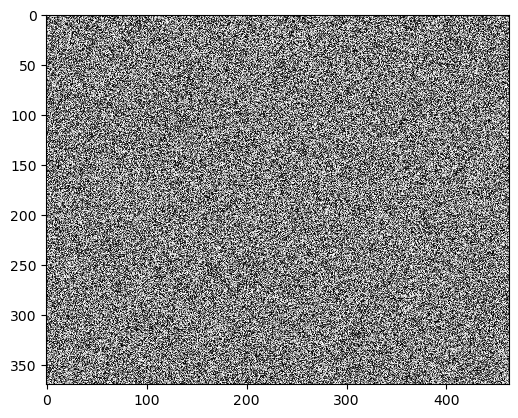

In [79]:
img0 = cv.imread("view1.png", cv.IMREAD_GRAYSCALE)
output = img0
img1 = cv.imread("view5.png", cv.IMREAD_GRAYSCALE)

h = img0.shape[0]#rows
w = img0.shape[1]#cols

blocksize = 5
for i in range(h): #for each row of left image
    print("current row: ", i)
    for j in range(w): #for each pixel in the current row
        #print("current col: ", j)
        differences = []#should be size w
        for r in range(w): #for every corresponding right image pixel in this row, R SHOULD ONLY STEP MAXIMUM DISPARITY AWAY FROM J
            currDiff = 0#if not valid, remains zero
            for bh in range(i-int(blocksize/2), i+1+int(blocksize/2)):#vertical block component Starting from upper left corner of block?
                #for bw in range(j-int(blocksize/2), j+1+int(blocksize/2)):
                for bw in range(r-int(blocksize/2), r+1+int(blocksize/2)):#changed to r for current right image location    
                    if((bh>-1 and bh<h) and(bw>-1 and bw<w) and (j+(bw-r)<w and j+(bw-r)>-1)): #proceed if no bound violation, does not include those values
                        #currDiff += (img0[i,j]-img1[bh,bw])**2  #THIS LINE IS THOROUGHLY WRONG, NEEDS CHANGING
                        currDiff += (img0[bh,j+(bw-r)]-img1[bh,bw])**2
                        #currDiff += (img0[bh,bw]-img1[bh,bw])**2
            differences.append(currDiff)#THIS LINE MIGHT CAUSE PROBLEMS
            #differences[r] = currDiff
        match = min(differences)
        d = j - match #will this always be positive given our orientation?
        #now just plug into corresponding index
        output[i,j] = d

plt.imshow(output,'gray')
plt.show()
#Could finalize output by running an occlusion filling routine
        


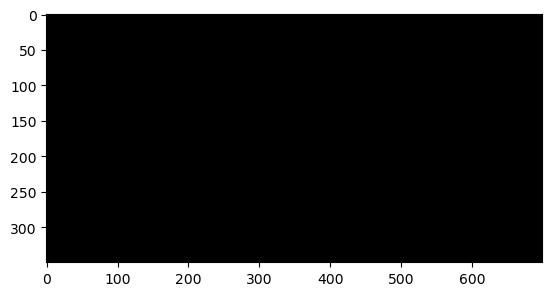

In [64]:
output = np.ones((350, 700), dtype = np.uint8)
#output = 254 * output
plt.imshow(output,'gray')
plt.show()

disparity range 0-64, set max offset as 64
Make sure blocks don't overlap during checking block checking

Processing.. 98% complete

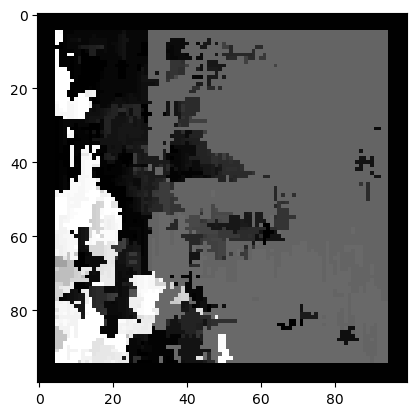